In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [2]:
WIDTH  = 0.5
FONT = 24

BLUE = "#788ae3"
RED = "#d1545e"
DARKBLUE = "#075cb3"
DARKRED = "#8c1822"

In [3]:
def unzip_data_npz(root_dir, destination_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if 'data.npz' in filenames:
            npz_path = os.path.join(dirpath, 'data.npz')
            relative_path = os.path.relpath(dirpath, root_dir)
            data_dir = os.path.join(destination_dir, relative_path, 'data')

            #avoid overwriting
            if not os.path.exists(data_dir) or not any(os.scandir(data_dir)):
                try:
                    with np.load(npz_path, allow_pickle=True) as data:
                        os.makedirs(data_dir, exist_ok=True)
                        for key, value in data.items():
                            np.save(os.path.join(data_dir, f"{key}.npy"), value)
                except Exception as e:
                    print(f"Error unzipping {npz_path}: {str(e)}")

In [4]:
target = 'D1'
method = 'nelder-mead'

root_directory = f'../optimization_data/{target}_{method}/'
unzip_directory = f'../opt_test_unzipped/{target}_{method}/'
print(root_directory)
print(unzip_directory)
#unzip_data_npz(root_directory, unzip_directory)

../optimization_data/D1_nelder-mead/
../opt_test_unzipped/D1_nelder-mead/


In [6]:
path = os.path.join('../', root_directory, 'data/')

rb_paths = [item for item in os.listdir(path) if item.startswith('rb_ondevice') 
            and os.path.isdir(os.path.join(path, item))]
sorted_rb_items = sorted(rb_paths, key=lambda x: int(x.split('-')[1]))
print(len(sorted_rb_items))

175


In [7]:
all_decay_params, all_decay_errs = [], []
for rbpath in sorted_rb_items:
    with open(f"{path}{rbpath}/results.json") as f:
        data_dict = json.load(f)
    popt = data_dict['"pars"']['"D1"']
    pcov = np.array(data_dict['"cov"']['"D1"']).reshape(3,3)
    perr = np.sqrt(np.diag(pcov))
    all_decay_params.append(popt[2])
    all_decay_errs.append(perr[2])

all_decay_params, all_decay_errs = np.array(all_decay_params), np.array(all_decay_errs)
#print(all_decay_params, all_decay_errs)

infidelity = (1 - all_decay_params) / 2
pulse_fidelities = 1 - infidelity / 1.875

pulse_fidelities_err = all_decay_errs / (1.875 * 2)


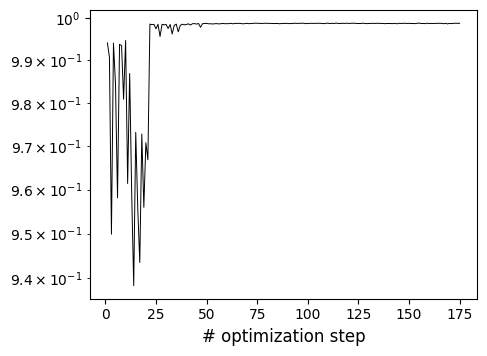

In [8]:
x = np.arange(1, len(pulse_fidelities) + 1)

fig, ax1 = plt.subplots(1, figsize=(WIDTH * 10 , WIDTH * 10 * 6/8))
#ax1.errorbar(x, pulse_fidelities, yerr = pulse_fidelities_err, fmt='o',linestyle='none', 
#             markersize=4, color="black", markerfacecolor=RED, ecolor="black", markeredgewidth=0.7, elinewidth=0.7, alpha=1, label=r"qubit 1", capsize=3)
ax1.plot(x, pulse_fidelities, '-', color='black', linewidth=0.7)
ax1.set_xlabel('# optimization step',  fontsize=12)
ax1.set_yscale('log')
plt.savefig('first_plot', bbox_inches="tight", dpi=600)


In [9]:
loaded = np.load('optimization_history.npz')
iterations = loaded['iterations']
parameters = loaded['parameters']
objective_values = loaded['objective_values']

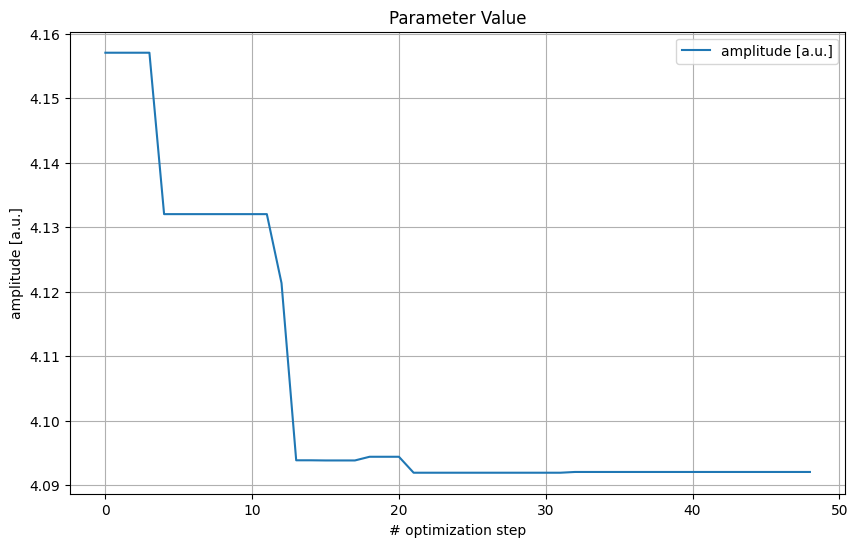

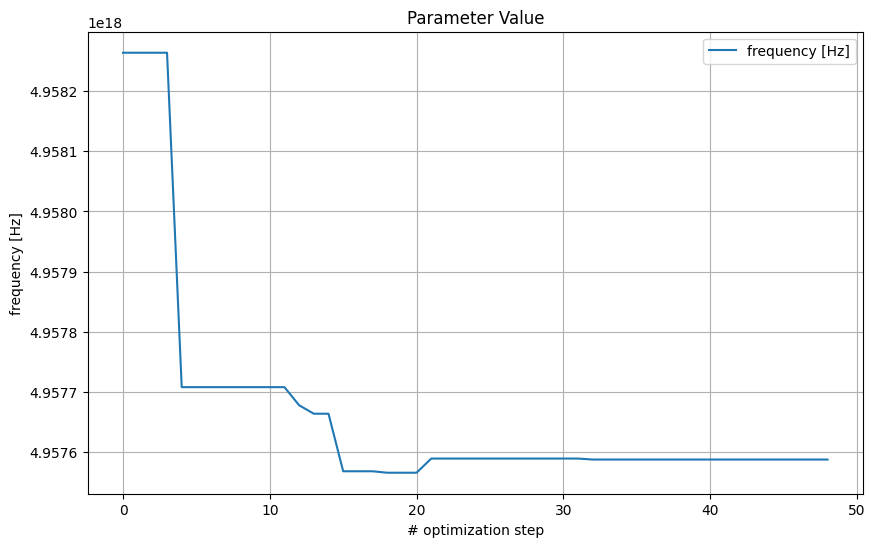

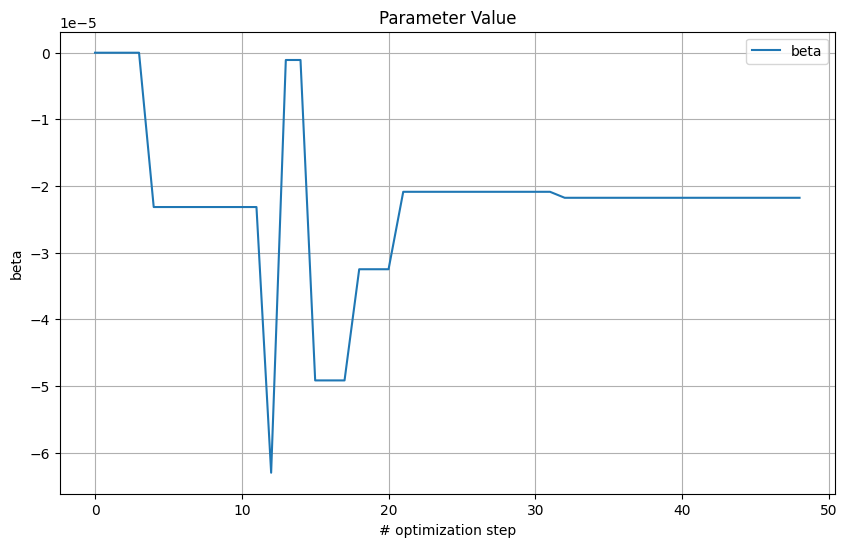

In [10]:
# Plot each parameter as a function of the iteration step
params_name = ['amplitude [a.u.]', 'frequency [Hz]', 'beta']

for i in range(parameters.shape[1]):
    plt.figure(figsize=(10, 6))  # Create a new figure for each parameter
    plt.plot(iterations, parameters[:, i], label=f'{params_name[i]}')
    plt.xlabel('# optimization step')
    plt.ylabel(f'{params_name[i]}')
    plt.title('Parameter Value')
    plt.legend()
    plt.grid()
    plt.show()

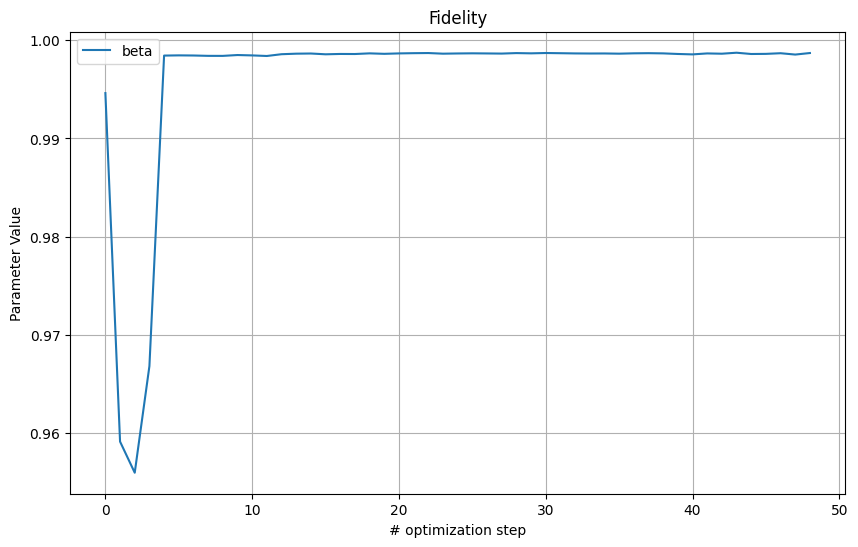

In [11]:
plt.figure(figsize=(10, 6))  # Create a new figure for each parameter
plt.plot(iterations, 1-objective_values, label=f'{params_name[i]}')
plt.xlabel('# optimization step')
plt.ylabel('Parameter Value')
plt.title(f'Fidelity')
plt.legend()
plt.grid()
plt.show()